In [22]:
import math
import numpy as np
import random
import decimal
import matplotlib.pyplot as plt
import torch
import seaborn as sns

#Now to implement q learning and variants on the above market environment
import sys
if "../" not in sys.path:
  sys.path.append("../") 

#from lib.utes import run_experiment, plot_values, plot_greedy_policy, \
#                        plot_action_values, random_policy, plot_state_value

#from lib.envs.grid import Grid, FeatureGrid, AltGrid
#from TD import  GeneralQ, ExperienceQ, DynaQ #, FeatureExperienceQ, FeatureDynaQ
#from FA.model import TabularModel #, LinearModel
#from Tabular import ExpTabAgent

from lib.envs.market import Market
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step
    
from lib.sim_prices import make_prices, run_stepsim_fixedprop
from lib.execute_strat import execute_strat

%matplotlib inline

In [23]:
"""Important to store and set the different parameters
perhaps pass in a dictionary of parameters each time to avoid silly errors

Experiment 1: Setup
mu 0.11, rf 0.10, sigma 0.028
M=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, 
u_star = np.linspace(-10,25, utes)

sims 300,000
kappa 0.008

eps greedy 0.1, learning rate 0.1, gamma 0.95
All the different models
do risk free in build up and log utility based results, also show extreme risk aversion

(do we vary kappa?)


Experiment 2: Higher volatility - can it be learned? Show the problems...perhaps its a trade off
of number of episodes

mu 0.11, rf 0.10, sigma 0.1
M=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, 
u_star = np.linspace(-1,1.5, utes)

sims 300,000
kappa 0.007 - trying different values for kappa

eps greedy 0.1, learning rate 0.1, gamma 0.95


Experiment 3: Another utility curve as per experiment 1
One I can parameterise with risk aversion and show the RL learns it...


Experiment 4: Scaling up - alternative RL methods


Experiment 5: Different price processes - maybe trade OU first?
Then see if we can beat merton with a non gbm process?


Chapters ?
Intro
Risk Neutral and Risk Averse
Utilities
Single Period Investing
The Merton Problem - Multi Period Optimality
Stochastic Optimal Control - The solution
Reinforcement Learning
Basic Methods
Problem Setting for RL - myopic investing
RL difficulties
Some examples - vols, means...
Learning Merton Experimental setting - from Myopic to mean variance equivalance
Low Vol results (diff RL algos)
High Vol - trade off with episodes?
Increasing the difference between rf and mu
Different Utility curves - learning increasing risk aversion
Scaling up - RL
Continuous setting
Realistic price processes - beating Merton
Gaussian Processes
Reducing sample numbers with a semi-parametric approach (hypothesising a set of prior kernels
rather than learning purely from the data)
"""

'Important to store and set the different parameters\nperhaps pass in a dictionary of parameters each time to avoid silly errors\n\nExperiment 1: Setup\nmu 0.11, rf 0.10, sigma 0.028\nM=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, \nu_star = np.linspace(-10,25, utes)\n\nsims 300,000\nkappa 0.008\n\neps greedy 0.1, learning rate 0.1, gamma 0.95\nAll the different models\ndo risk free in build up and log utility based results, also show extreme risk aversion\n\n(do we vary kappa?)\n\n\nExperiment 2: Higher volatility - can it be learned? Show the problems...perhaps its a trade off\nof number of episodes\n\nmu 0.11, rf 0.10, sigma 0.1\nM=20, T=1.0, utes = 15, S0=1, B0=1, X0=100, wealth = X0, merton 12.75, \nu_star = np.linspace(-1,1.5, utes)\n\nsims 300,000\nkappa 0.007 - trying different values for kappa\n\neps greedy 0.1, learning rate 0.1, gamma 0.95\n\n\nExperiment 3: Another utility curve as per experiment 1\nOne I can parameterise with risk aversion and show 

In [45]:
#Set parameters
mu =0.10 #save these paramters mu 0.11, rf 0.10, sigma 0.028
rf = 0.02
M = 20 #so 20 time periods or 50 still works...just longer to train and run, u_star = np.linspace(-10,25, utes)

time_periods = M
T = 1.0
dt = T/M
utes = 15
#u_star = np.linspace(-10,25, utes) #this is specific to the above parameters

kappa = 0.008


#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0

lowvol =False

#file = 'LogUteNoisy1epi3000000er8kappa0.0.npy'
if lowvol:
    u_star = np.linspace(-10,25, utes)
    sigma = 0.028
else:
    u_star = np.linspace(0,5, utes)
    sigma = 0.20
    #sigma = 0.20
    
    
    

In [46]:
#From the ritter paper he then instead of calculating the mean variance equivalent
#form at the end, turned this into an incremental reward. He did this for trading an OU
#process showing q learning could find an arbitrage - the step by step is dx - kappa*(dx**2)

#Using the same set up I hoped to be able to approach mertons problem with RL
#the agent won't know the price process, it will have 15 different investment possibilities
#at each time, it will know its wealth level, and have an action of how much to invest.
#each step this order will be executed by the market agent and it will receive a reward. 

#Difficulty one - the agent has no control of much of the next state...it is effectively choosing
#between different probability distributions over wealth, the price process is noisy and independent of
#it, thus the action doesn't control much of the next environment.

#Difficulty two - even a low vol levels, the rewards are noisy and can be misleading. The agent
#does not know that 'the answer' is a constant investment ratio, it must explore.

In [47]:
#The merton ratio leads to a constant ratio for GBM log utility
#note this is a very high leverage because of the low vol
#I did this due to difficulties getting RL to learn anything 
#and we can play around with how to solve this

merton_ratio = (mu-rf)/sigma**2
merton_ratio #the ratio to invest

merton_value = np.log(X0) + (rf + ((mu-rf)/2*sigma**2))

print(merton_ratio, merton_value)

1.9999999999999996 4.626770185988092


In [48]:
print(np.log(X0) + (rf + ((mu-rf)**2/2*sigma**2)))

4.6252981859880915


In [49]:
#Ritters paper looks at mean variance equivalence distributions
#he can thus convert with a parameter kappa the above utility to 
#a mean variance trade off...this is possible for all mean variance equiv distn
#and upward sloping utility function (of which log is)

def mv_equiv(kappa, mean, variance):
    return mean - (kappa/2)*variance

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
print(best_action)
print(u_star[best_action])
u_star

6
2.142857142857143


array([0.        , 0.35714286, 0.71428571, 1.07142857, 1.42857143,
       1.78571429, 2.14285714, 2.5       , 2.85714286, 3.21428571,
       3.57142857, 3.92857143, 4.28571429, 4.64285714, 5.        ])

In [29]:
num_sims =300000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
utility[best_action]
u_star[best_action] #12.5 is the closest we have to merton which is 12.7

101.91816486174086
75.97654669074419
56.14747149871638
41.10531532815509
29.78722728137715
21.345930038722216
15.11011618932439
10.551362106590151
7.2566130378200135
4.905411622767688
3.2511482528349402
2.1057065253281846
1.3269614800474494
0.7969578231774144
0.4038255261032166


2.142857142857143

In [44]:
best_action

6

In [30]:
#this gives mean variance equivalent end of episode values
kappa = 0.008
vals = mv_equiv(kappa, means, variances)

In [31]:
#Run a reward step by step simulation with fixed investment levels to check this looks
#similar to the utility set up

episodes = 200000
kappa = 0.008
mean_rewards, mean_utes, all_wealth = run_stepsim_fixedprop(kappa, mu, sigma, rf,
                                                            u_star, Market, wealth, episodes=200000, time_periods=20)

Inv ratio:  0.0 Mean log utility:  4.624170185988092
Inv ratio:  0.0 Mean Reward:  1.9173902371478204
Min wealth:  101.91816486174086 Max Wealth:  101.91816486174086
Inv ratio:  0.35714285714285715 Mean log utility:  4.649110476755835
Inv ratio:  0.35714285714285715 Mean Reward:  4.538226443412026
Min wealth:  79.01173594568301 Max Wealth:  142.54108670350305
Inv ratio:  0.7142857142857143 Mean log utility:  4.6689786124434
Inv ratio:  0.7142857142857143 Mean Reward:  6.770948380769287
Min wealth:  58.04334628628728 Max Wealth:  201.71538330150878
Inv ratio:  1.0714285714285714 Mean log utility:  4.683385720781427
Inv ratio:  1.0714285714285714 Mean Reward:  8.503158520023884
Min wealth:  43.01074679866501 Max Wealth:  267.5272676003117
Inv ratio:  1.4285714285714286 Mean log utility:  4.693005329701192
Inv ratio:  1.4285714285714286 Mean Reward:  9.77164031221551
Min wealth:  29.460310668240382 Max Wealth:  390.6344140261341
Inv ratio:  1.7857142857142858 Mean log utility:  4.69945941

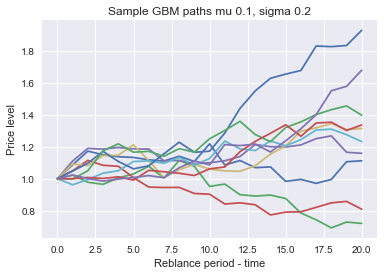

In [32]:
plot_sample_paths(S, mu, sigma)

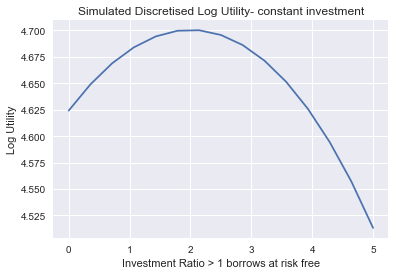

In [33]:
plot_disc_utility(u_star,utility)

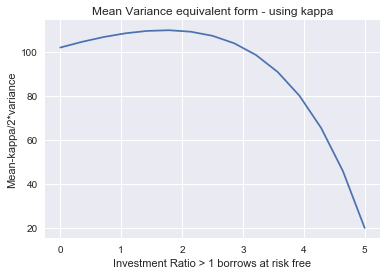

In [34]:
plot_mv_equiv(u_star, vals)

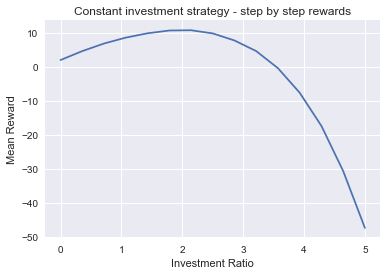

In [35]:
plot_const_step(u_star,mean_rewards)

In [36]:
#####be sure to calibrate kappa in the same way as the training for the agent
#kappa = 0.006

#run the various baseline graphs pre agent
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth)

#block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
#block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)

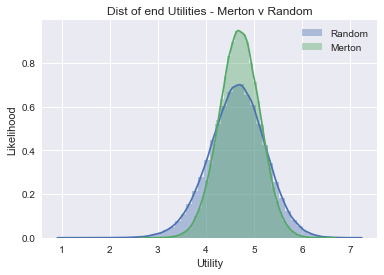

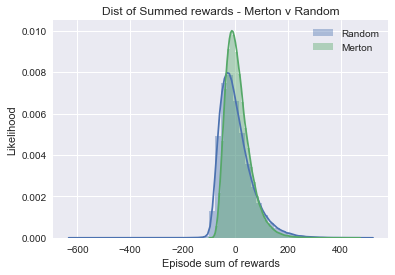

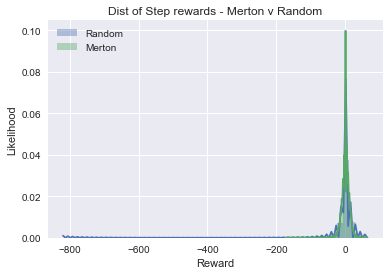

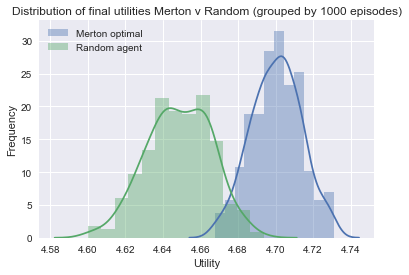

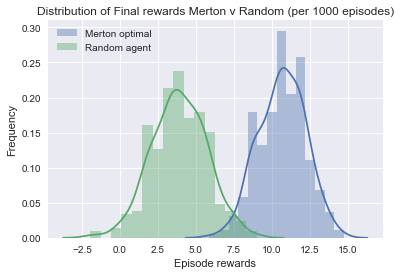

In [37]:
make_baseline_graphs(utilities_test_rand,utilities_test_best,
                         rewards_test_rand,rewards_test_best, step_rew_rand, step_rew_best)

gymtest.npy


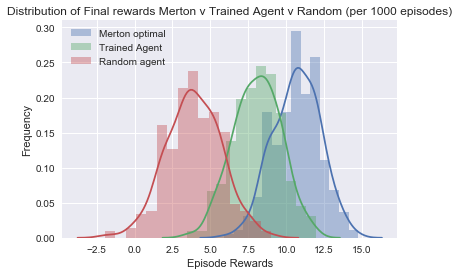

../lib/graphs.py:134: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


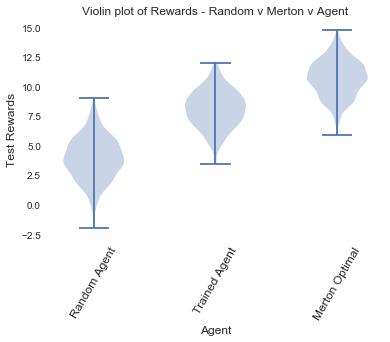

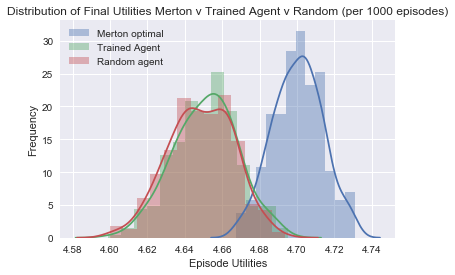

../lib/graphs.py:154: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


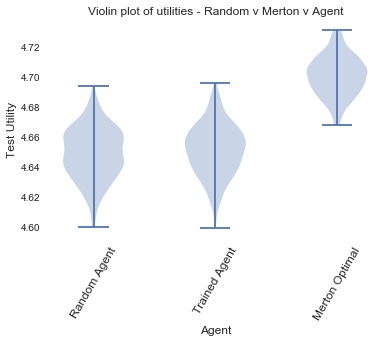

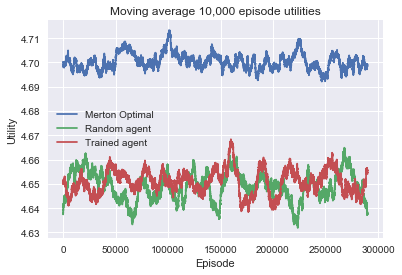

../lib/graphs.py:173: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


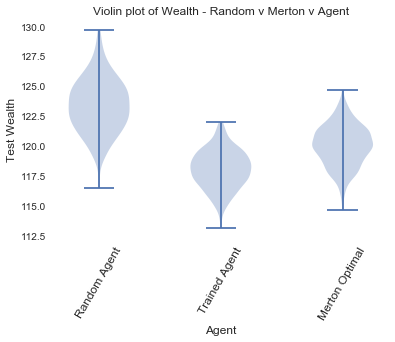

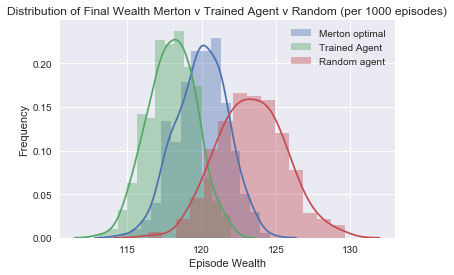

../lib/graphs.py:193: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


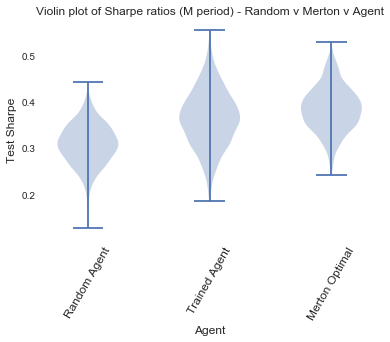

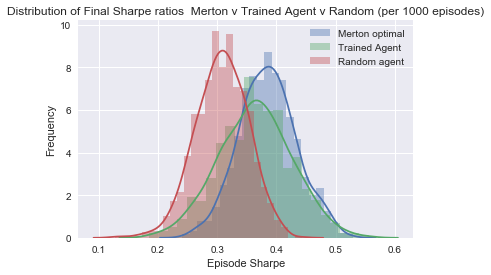

In [41]:
#Now with the trained agent
import os
path = '/Users/johngoodacre/Desktop/RLMerton/rl/td/q_tables/models'
files = os.listdir(path)

#Q = np.load('q_tables/prior_runs/best_q_so_far.npy')
#Q = np.load('q_tables/models/2epi3000000er8.npy')

#for file in files:
#    Q = np.load(path+'/'+file)
#    print(file)

#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa1.0.npy') = this gave some v nice results...
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa2.0.npy') and this was very bad??
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa3.0.npy') this looked good also
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa4.0.npy') very strong


#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa9.0.npy') not so convincing
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa10.0.npy') bad
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa11.0.npy') not great
#Q = np.load('q_tables/models/Noisy2epi3000000er8kappa13.0.npy') good risk averse

#Q = np.load('q_tables/models/LowVol2epi3000000er8kappa0.0.npy') #this is good...risk neutrality demo
#Q = np.load('q_tables/models/LowVol2epi3000000er8kappa9.0.npy') not convincing
#Q = np.load('q_tables/models/LogUteLowVol2epi3000000er8kappa8.0.npy') using utes - looks good

#LogUteNoisy1epi3000000er8kappa0.0.npy velly nice


#Q = np.load('q_tables/models/LogUteNoisy1epi3000000er8kappa1.0.npy') #this works


#path = '/Users/johngoodacre/Desktop/RLMerton/rl/td/q_tables/models'
#files = os.listdir(path)

results = []

#Q = np.load('q_tables/diffmodels/LogUteNoisy1epi3000000er8kappa1.0.npy')
#Q = np.load('q_tables/diffmodels/LogUteNoisy3epi3000000er8kappa130.0.npy')


path = '/Users/johngoodacre/Desktop/RLMerton/rl/td/q_tables/diffmodels/'
path = '/Users/johngoodacre/Desktop/RLMerton/RL/lib/envs/'
files = os.listdir(path)


for file in files:
    if 'gymtest.npy' in file:
        print(file)

        Q = np.load(path+'/'+file)
        utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, 
                                        u_star,best_action, 'Agent', q_values=Q, 
                                        time_periods=time_periods, wealth=wealth)


        res = make_agent_graphs(rewards_test_best, rewards_test_rand, rewards_test,
              utilities_test_best, utilities_test_rand, utilities_test,
             wealth_test_rand, wealth_test_best, wealth_test)
        results.append(res)

In [42]:
for r in res:
    print(np.std(r))
    #print(np.mean(r)+np.log(100))

0.01724671767993952
0.017182427879925317
0.013278220321886752
1.8020334302951062
1.563209783648822
1.535068261258006
2.2542829513199876
1.5933538992028886
1.6998803523543613
0.04427881659852053
0.06190164437764324
0.048272657043933666


In [43]:
Q[5:15,:]

array([[ 9.41944039,  9.46160636,  9.41244839, 10.03979797,  9.64964611,
         9.22610916,  9.86854086,  9.58250704,  8.74018603,  9.05570891,
         9.34673232,  9.22772762,  9.41293141,  8.95815131, 11.24819187],
       [ 9.25906927,  9.23501806,  9.04650442,  9.05669618,  9.16080258,
         9.02665836, 12.49984963,  9.18167023,  8.85207917,  8.95034484,
         7.56209007,  8.91255515,  7.45388394,  7.50988161,  8.88916947],
       [ 8.40003954,  8.6102568 ,  8.99705928,  8.41493592,  8.25729122,
         8.66968284,  8.20218539,  8.3837255 ,  7.92516164,  8.14320573,
         7.96098672,  8.32851731, 10.58552511,  6.34245632,  6.85580062],
       [ 9.01104392,  8.19315871,  8.34465553,  8.82577913,  8.35527093,
         7.92611539,  9.86452118,  8.21010002,  7.11386092,  7.92091219,
         9.11065438,  8.81034815,  8.9911051 , 14.05124773,  8.3231688 ],
       [ 9.22103063, 10.60862688,  9.53661333,  9.46221417,  8.41843427,
         8.80760093, 10.2577833 ,  8.35211276, 